# Libraries

In [1]:
import random

from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Subset
from torch.optim import AdamW
import torch_geometric as pyg
from torch_geometric.nn.pool import global_mean_pool
from torch_geometric.data import Dataset
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
from torch.nn import Linear, ReLU, Dropout
from torch_geometric.nn import Sequential, GCNConv, JumpingKnowledge, TAGConv, ARMAConv
from torch_geometric.nn import global_mean_pool
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
from rdkit import Chem
from rdkit.Chem import Draw

/Users/andrey/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Config

In [2]:
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = False
        


In [3]:
batch_size = 2048
epochs = 15
learning_rate = 1e-2
lr_warmup_steps = 500
quantile = 0.99
device = "mps"
random_state = 42

seed_everything(random_state)

In [4]:
def score(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f"Coefficient of determination (R²): {r2}")
    print(f"MAE: {mae}")
    print(f'MAPE: {mape}')

def plotter(y_train, train_pred, y_test, test_pred):
    plt.scatter(y_train, train_pred,c='green', label='Training')
    plt.plot(y_train, y_train, c='black')
    plt.scatter(y_test, test_pred,c='red', label='Test')
    plt.xlabel('Actual IC50', fontweight='bold')
    plt.ylabel('Predicted IC50', fontweight='bold')
    plt.legend(loc='upper right', numpoints=1, ncol=3, fontsize=8)

    plt.show()

# Data

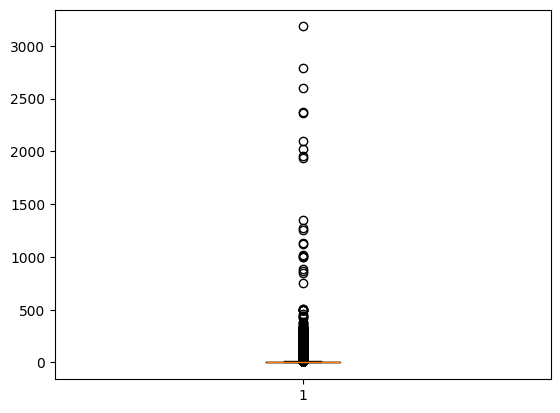

In [5]:
df = pd.read_excel("19_35000.xlsx", index_col=0).reset_index(drop=True)
plt.boxplot(x=df['IC50'])
plt.show()

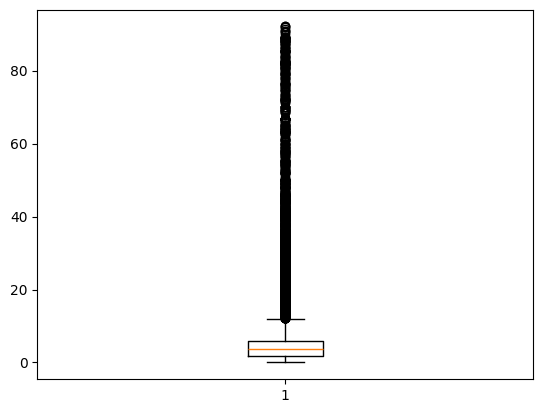

In [6]:
df = df[df['IC50'] < df['IC50'].quantile(quantile)]
plt.boxplot(x=df['IC50'])
plt.show()

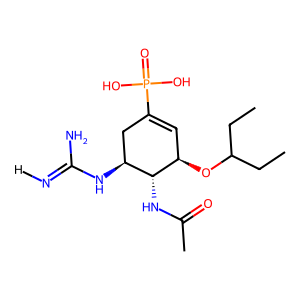

In [7]:
m = Chem.MolFromSmiles(df["SMILES"].tolist()[0])
img = Draw.MolToImage(m)
img

In [8]:
class MolDataset(Dataset):
    def __init__(self, df):
        super(MolDataset, self).__init__()
        self.smiles = df["SMILES"].tolist()
        self.target = df["IC50"].tolist()
        
    def __len__(self):
        return len(self.smiles)
        
        
    def __getitem__(self, idx):
        x = pyg.utils.smiles.from_smiles(self.smiles[idx])
        return x, self.target[idx]

In [9]:
train_ids, test_ids = train_test_split(np.arange(len(df)), test_size=0.2)
test_ids, val_ids = train_test_split(test_ids, test_size=0.5)

In [10]:
dataset = MolDataset(df)

train_loader = DataLoader(
    Subset(dataset, train_ids),
    shuffle=True,
    batch_size=batch_size
)

eval_loader = DataLoader(
    Subset(dataset, val_ids),
    shuffle=True,
    batch_size=batch_size
)

test_loader = DataLoader(
    Subset(dataset, test_ids),
    shuffle=True,
    batch_size=batch_size
)

In [11]:
def train_epoch(model, loader, loss_function, optimizer, device):
    model.train()
    model.to(device)
    loss_function.to(device)
    
    preds = []
    targets = []
    total_loss = 0.
    
    for batch in tqdm(loader):
        data, y = batch
        data, y = data.to(device), y.to(device)
        output = model(data)
        
        loss = loss_function(output.flatten(),y.flatten())
        
        total_loss += loss.item()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()

        preds.append(output.flatten())
        targets.append(y.flatten())
    
    preds = torch.cat(preds, dim=0).detach().cpu()
    targets = torch.cat(targets, dim=0).detach().cpu()
    mae = loss_function(targets, preds).item()

    return {"TRAIN Loss": {total_loss / len(loader)}, "MAE": {mae}, "R2": r2_score(targets.numpy(), preds.numpy())}
        
        
def eval_epoch(model, loader, loss_function, device):
    model.eval()
    model.to(device)
    loss_function.to(device)
    
    preds = []
    targets = []
    total_loss = 0.
    
    for batch in tqdm(loader):
        data, y = batch
        data, y = data.to(device), y.to(device)
        
        with torch.no_grad():
            output = model(data)
        
        loss = loss_function(output.flatten(),y.flatten())
        
        total_loss += loss.item()
        
        preds.append(output.flatten())
        targets.append(y.flatten())
    
    preds = torch.cat(preds, dim=0).detach().cpu()
    targets = torch.cat(targets, dim=0).detach().cpu()
    mae = loss_function(targets, preds).item()

    return {"EVAL Loss": {total_loss / len(loader)}, "MAE": {mae}, "R2": r2_score(targets.numpy(), preds.numpy()), "preds": preds, "targets": targets}

def train(model, train_loader, eval_loader, loss_function, optimizer):
    train_logs, eval_logs = [], []
    for i in range(epochs):
        train_log = train_epoch(
            model=model, 
            loader=train_loader, 
            loss_function=loss_function, 
            optimizer=optimizer,
            device=device
        )
        
        eval_log = eval_epoch(
            model=model, 
            loader=eval_loader, 
            loss_function=loss_function, 
            device=device
        )

        print(train_log, eval_log)
        
        train_logs.append(train_log)
        eval_logs.append(eval_log)
    return train_logs, eval_logs

# GCNConv Model

In [12]:
class GCNConvModel(torch.nn.Module):
    def __init__(self, input_channels, hidden_dim=64):
        super(GCNConvModel, self).__init__()
        self.model = Sequential('x, edge_index, batch', [
                (Dropout(p=0.5), 'x -> x'),
                (GCNConv(input_channels, hidden_dim), 'x, edge_index -> x1'),
                ReLU(inplace=True),
                (GCNConv(hidden_dim, hidden_dim), 'x1, edge_index -> x2'),
                ReLU(inplace=True),
                (lambda x1, x2: [x1, x2], 'x1, x2 -> xs'),
                (JumpingKnowledge("cat", hidden_dim, num_layers=2), 'xs -> x'),
                (global_mean_pool, 'x, batch -> x'),
                Linear(2 * hidden_dim, 1),
            ])

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x.float(), data.edge_index, data.edge_attr.float(), data.batch
        out = self.model(x, edge_index, batch)
        return out

In [13]:
model = GCNConvModel(9, 64)
optimizer = AdamW(model.parameters(), lr=learning_rate)
loss_function = torch.nn.L1Loss()

logs = train(model, train_loader, eval_loader, loss_function, optimizer)

100%|██████████| 2/2 [00:01<00:00,  1.40it/s]


{'TRAIN Loss': {3.414468256632487}, 'MAE': {3.4923651218414307}, 'R2': -0.08761246725901262} {'EVAL Loss': {3.1407400369644165}, 'MAE': {3.14900541305542}, 'R2': -0.019710582683695632, 'preds': tensor([3.7683, 4.2168, 3.8119,  ..., 3.7609, 3.8133, 3.8649]), 'targets': tensor([ 0.0730,  0.5340,  4.5250,  ...,  4.5390,  4.1790, 13.4560])}


100%|██████████| 2/2 [00:01<00:00,  1.43it/s]


{'TRAIN Loss': {3.187435340881348}, 'MAE': {3.2207419872283936}, 'R2': -0.031488520420826616} {'EVAL Loss': {3.209609627723694}, 'MAE': {3.1812477111816406}, 'R2': -0.0650335641729769, 'preds': tensor([2.9080, 2.9885, 3.0725,  ..., 3.0831, 3.0227, 3.0172]), 'targets': tensor([1.8290, 5.6930, 0.0870,  ..., 2.4590, 4.4250, 3.3840])}


100%|██████████| 2/2 [00:01<00:00,  1.31it/s]


{'TRAIN Loss': {3.1522634824117026}, 'MAE': {3.193999767303467}, 'R2': -0.03212069228104619} {'EVAL Loss': {3.138170599937439}, 'MAE': {3.140164613723755}, 'R2': -0.04224511387135865, 'preds': tensor([3.2211, 3.2896, 3.4504,  ..., 3.2542, 3.4413, 3.4804]), 'targets': tensor([3.8310, 6.5120, 4.5950,  ..., 0.9050, 4.2550, 6.7870])}


100%|██████████| 2/2 [00:01<00:00,  1.35it/s]


{'TRAIN Loss': {3.15420347849528}, 'MAE': {3.1907553672790527}, 'R2': -0.030762834242633152} {'EVAL Loss': {3.1470329761505127}, 'MAE': {3.1497068405151367}, 'R2': -0.048535639440609346, 'preds': tensor([3.1450, 3.3275, 3.2906,  ..., 3.1867, 3.1867, 3.1516]), 'targets': tensor([33.4000,  4.0750, 25.0800,  ...,  3.7000,  1.2000,  1.4850])}


100%|██████████| 2/2 [00:01<00:00,  1.18it/s]


{'TRAIN Loss': {3.1793322881062824}, 'MAE': {3.1859188079833984}, 'R2': -0.028708723596668095} {'EVAL Loss': {3.1559966802597046}, 'MAE': {3.149151086807251}, 'R2': -0.047197160767882274, 'preds': tensor([3.1736, 3.3417, 3.1506,  ..., 3.3547, 3.2989, 3.3203]), 'targets': tensor([1.8830, 3.8060, 3.6550,  ..., 7.5480, 4.1550, 7.8710])}


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


{'TRAIN Loss': {3.2228283087412515}, 'MAE': {3.1850430965423584}, 'R2': -0.027787633861201533} {'EVAL Loss': {3.2416248321533203}, 'MAE': {3.2242987155914307}, 'R2': -0.07848433381324416, 'preds': tensor([2.7962, 2.7541, 2.7147,  ..., 3.0287, 2.6871, 2.7796]), 'targets': tensor([3.2980, 6.1330, 2.4830,  ..., 3.5900, 1.3550, 0.6200])}


100%|██████████| 2/2 [00:01<00:00,  1.12it/s]


{'TRAIN Loss': {3.2783341725667317}, 'MAE': {3.1927855014801025}, 'R2': -0.029460665651564133} {'EVAL Loss': {3.1682755947113037}, 'MAE': {3.1447134017944336}, 'R2': -0.04474787541621761, 'preds': tensor([3.3786, 3.2349, 3.2951,  ..., 3.1445, 3.4551, 3.2193]), 'targets': tensor([4.8580, 4.8060, 1.5110,  ..., 5.8200, 3.8730, 3.8190])}


100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


{'TRAIN Loss': {3.2667386690775553}, 'MAE': {3.18633770942688}, 'R2': -0.028652010498534608} {'EVAL Loss': {3.1600197553634644}, 'MAE': {3.1667840480804443}, 'R2': -0.0565449369159845, 'preds': tensor([3.0630, 2.9235, 3.0714,  ..., 3.2272, 3.0316, 3.0327]), 'targets': tensor([6.9710, 0.4130, 2.8550,  ..., 7.9200, 0.4490, 6.4400])}


100%|██████████| 2/2 [00:01<00:00,  1.15it/s]


{'TRAIN Loss': {3.1382516543070476}, 'MAE': {3.1816749572753906}, 'R2': -0.02639253764353633} {'EVAL Loss': {3.2527244091033936}, 'MAE': {3.218588352203369}, 'R2': -0.07597184605986285, 'preds': tensor([2.9094, 2.9832, 2.9669,  ..., 2.6733, 2.8171, 2.8047]), 'targets': tensor([0.3850, 0.7030, 5.1110,  ..., 0.4010, 3.7240, 9.0970])}


100%|██████████| 2/2 [00:02<00:00,  1.12s/it]


{'TRAIN Loss': {3.1991588751475017}, 'MAE': {3.187276840209961}, 'R2': -0.029371933038699227} {'EVAL Loss': {3.2336548566818237}, 'MAE': {3.2122251987457275}, 'R2': -0.07315430447238613, 'preds': tensor([2.7919, 2.7003, 2.8787,  ..., 2.8372, 3.2618, 2.8919]), 'targets': tensor([ 0.8720,  2.4690, 38.9670,  ...,  3.1480,  2.4370,  2.9720])}


100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


{'TRAIN Loss': {3.1488736152648924}, 'MAE': {3.1817541122436523}, 'R2': -0.026310298639928398} {'EVAL Loss': {3.156221866607666}, 'MAE': {3.158234119415283}, 'R2': -0.050962839548960526, 'preds': tensor([3.2411, 3.1454, 3.0237,  ..., 3.0518, 2.9642, 3.4393]), 'targets': tensor([7.5710e+00, 1.8680e+00, 6.7110e+00,  ..., 1.0227e+01, 2.2490e+00,
        2.2465e-04])}


100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


{'TRAIN Loss': {3.1362475713094073}, 'MAE': {3.184220314025879}, 'R2': -0.02539671523212572} {'EVAL Loss': {3.2215893268585205}, 'MAE': {3.2472047805786133}, 'R2': -0.08417691348769973, 'preds': tensor([2.6937, 2.9211, 3.0356,  ..., 2.6141, 2.7964, 2.9108]), 'targets': tensor([7.6500e-01, 9.4500e-01, 8.0290e-04,  ..., 1.3220e+00, 7.4600e+00,
        2.0630e+00])}


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


{'TRAIN Loss': {3.1470372994740803}, 'MAE': {3.185601234436035}, 'R2': -0.029514797493014777} {'EVAL Loss': {3.1189661026000977}, 'MAE': {3.1581239700317383}, 'R2': -0.05088779315770364, 'preds': tensor([3.2219, 3.3022, 3.1737,  ..., 3.4945, 3.8824, 3.1303]), 'targets': tensor([9.7220, 5.1230, 0.2840,  ..., 0.0180, 1.0000, 4.1950])}


100%|██████████| 2/2 [00:02<00:00,  1.21s/it]


{'TRAIN Loss': {3.1472452163696287}, 'MAE': {3.1804935932159424}, 'R2': -0.02705374901493962} {'EVAL Loss': {3.141621470451355}, 'MAE': {3.1565845012664795}, 'R2': -0.05050161580877055, 'preds': tensor([3.1775, 3.1024, 3.2950,  ..., 3.0500, 3.1133, 3.1526]), 'targets': tensor([10.4760,  1.0860,  0.3860,  ...,  6.7110,  5.5140,  3.8950])}


100%|██████████| 2/2 [00:02<00:00,  1.15s/it]

{'TRAIN Loss': {3.1452247778574627}, 'MAE': {3.183925151824951}, 'R2': -0.02868341225891413} {'EVAL Loss': {3.1614551544189453}, 'MAE': {3.1673009395599365}, 'R2': -0.055687638538473694, 'preds': tensor([3.1270, 3.3505, 2.9337,  ..., 3.0638, 3.0408, 3.0947]), 'targets': tensor([ 1.4490,  0.3140,  6.9310,  ...,  4.1850, 46.5000,  3.5820])}


100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Coefficient of determination (R²): -0.05057315380453864
MAE: 3.1512160301208496
MAPE: 55.1007080078125


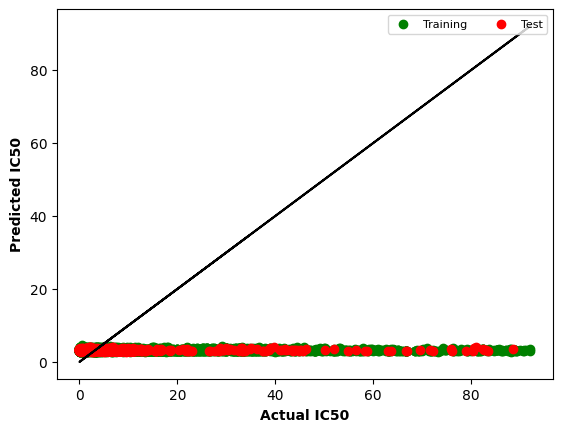

In [14]:
train_logs = eval_epoch(model, train_loader, loss_function, device)
y_train, train_preds = train_logs["targets"], train_logs["preds"]

test_logs = eval_epoch(model, test_loader, loss_function, device)
y_test, test_preds = test_logs["targets"], test_logs["preds"]
score(y_test, test_preds)
plotter(y_train, train_preds, y_test, test_preds)

In [15]:
class TAGConvModel(torch.nn.Module):
    def __init__(self, input_channels, hidden_dim=64):
        super(TAGConvModel, self).__init__()
        self.model = Sequential('x, edge_index, batch', [
                (Dropout(p=0.5), 'x -> x'),
                (TAGConv(input_channels, hidden_dim), 'x, edge_index -> x1'),
                ReLU(inplace=True),
                (TAGConv(hidden_dim, hidden_dim), 'x1, edge_index -> x2'),
                ReLU(inplace=True),
                (lambda x1, x2: [x1, x2], 'x1, x2 -> xs'),
                (JumpingKnowledge("cat", hidden_dim, num_layers=2), 'xs -> x'),
                (global_mean_pool, 'x, batch -> x'),
                Linear(2 * hidden_dim, 1),
            ])

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x.float(), data.edge_index, data.edge_attr.float(), data.batch
        out = self.model(x, edge_index, batch)
        return out

In [16]:
model = TAGConvModel(9, 64)
optimizer = AdamW(model.parameters(), lr=learning_rate)
loss_function = torch.nn.L1Loss()

logs = train(model, train_loader, eval_loader, loss_function, optimizer)

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:02<00:00,  1.24s/it]


{'TRAIN Loss': {4.027531782786052}, 'MAE': {4.096926689147949}, 'R2': -0.18522031608136258} {'EVAL Loss': {3.1671218872070312}, 'MAE': {3.1903152465820312}, 'R2': -0.06670414800830593, 'preds': tensor([2.9793, 2.9437, 3.2168,  ..., 3.0171, 3.2481, 2.9958]), 'targets': tensor([1.2970, 8.2430, 4.0800,  ..., 4.1150, 1.9740, 3.2920])}


100%|██████████| 2/2 [00:02<00:00,  1.26s/it]


{'TRAIN Loss': {3.2045544624328612}, 'MAE': {3.187037944793701}, 'R2': -0.029392743702378876} {'EVAL Loss': {3.342351198196411}, 'MAE': {3.3365962505340576}, 'R2': -0.11157184647709317, 'preds': tensor([2.6210, 2.4910, 2.5343,  ..., 2.6002, 2.4286, 2.2444]), 'targets': tensor([4.7670, 2.3020, 3.0240,  ..., 0.8890, 4.3310, 3.8710])}


100%|██████████| 2/2 [00:02<00:00,  1.47s/it]


{'TRAIN Loss': {3.20700626373291}, 'MAE': {3.1890511512756348}, 'R2': -0.02998901478092142} {'EVAL Loss': {3.2274829149246216}, 'MAE': {3.2310116291046143}, 'R2': -0.08022029785942775, 'preds': tensor([2.7587, 2.6092, 3.0903,  ..., 2.8675, 2.8332, 2.7869]), 'targets': tensor([10.8740,  5.1400,  2.9250,  ...,  8.5300,  3.1210,  8.0100])}


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


{'TRAIN Loss': {3.2003439903259276}, 'MAE': {3.1829655170440674}, 'R2': -0.029797392125883615} {'EVAL Loss': {3.2010215520858765}, 'MAE': {3.1883857250213623}, 'R2': -0.06448911912853794, 'preds': tensor([2.9010, 2.8376, 2.9385,  ..., 2.9394, 2.7823, 2.8774]), 'targets': tensor([2.7740, 0.8720, 5.3370,  ..., 8.7870, 4.3690, 2.2040])}


100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


{'TRAIN Loss': {3.145733880996704}, 'MAE': {3.207469940185547}, 'R2': -0.02782626093558771} {'EVAL Loss': {3.3082237243652344}, 'MAE': {3.3244757652282715}, 'R2': -0.10901883555847958, 'preds': tensor([2.5965, 2.4575, 2.4295,  ..., 2.3640, 2.4026, 2.4978]), 'targets': tensor([5.1450, 6.9710, 4.1210,  ..., 0.8770, 3.2280, 4.2350])}


100%|██████████| 2/2 [00:03<00:00,  1.81s/it]


{'TRAIN Loss': {3.2007896105448403}, 'MAE': {3.180893659591675}, 'R2': -0.029220171652891702} {'EVAL Loss': {3.3498787879943848}, 'MAE': {3.351975440979004}, 'R2': -0.11664841210177723, 'preds': tensor([2.3359, 2.4308, 2.3518,  ..., 2.3976, 2.3193, 2.4854]), 'targets': tensor([ 0.0680,  3.1650,  0.7900,  ...,  2.8980, 10.6000,  1.1290])}


100%|██████████| 2/2 [00:03<00:00,  1.73s/it]


{'TRAIN Loss': {3.1582997322082518}, 'MAE': {3.180630683898926}, 'R2': -0.027975994616333155} {'EVAL Loss': {3.3314709663391113}, 'MAE': {3.3261094093322754}, 'R2': -0.10797660965999212, 'preds': tensor([2.3938, 2.8266, 2.9204,  ..., 2.3190, 3.1379, 2.3867]), 'targets': tensor([ 0.9590, 17.4600,  2.9190,  ..., 42.2000,  1.1000,  0.9510])}


100%|██████████| 2/2 [00:02<00:00,  1.46s/it]


{'TRAIN Loss': {3.225789213180542}, 'MAE': {3.176565170288086}, 'R2': -0.026282200810017198} {'EVAL Loss': {3.418277382850647}, 'MAE': {3.427767276763916}, 'R2': -0.13699004855907693, 'preds': tensor([2.5466, 2.3494, 2.2051,  ..., 2.2490, 2.2896, 2.3469]), 'targets': tensor([ 3.1840, 32.3590,  0.7420,  ...,  3.1840,  1.1010,  0.8890])}


100%|██████████| 2/2 [00:03<00:00,  1.83s/it]


{'TRAIN Loss': {3.2409136454264322}, 'MAE': {3.192938804626465}, 'R2': -0.02775234685792105} {'EVAL Loss': {3.283217668533325}, 'MAE': {3.280587911605835}, 'R2': -0.09483389255247521, 'preds': tensor([2.6206, 2.5950, 2.6994,  ..., 2.6429, 2.8343, 2.4965]), 'targets': tensor([15.4540,  0.8200,  0.0410,  ..., 40.0460,  2.0910,  0.7900])}


100%|██████████| 2/2 [00:03<00:00,  1.84s/it]


{'TRAIN Loss': {3.165542999903361}, 'MAE': {3.1810097694396973}, 'R2': -0.028275522193449643} {'EVAL Loss': {3.3239070177078247}, 'MAE': {3.3309502601623535}, 'R2': -0.10965212363242727, 'preds': tensor([2.5047, 2.4435, 2.4539,  ..., 2.4871, 2.6895, 2.3731]), 'targets': tensor([ 0.7390,  3.2970,  3.2800,  ...,  3.9580, 25.0800,  4.9440])}


100%|██████████| 2/2 [00:03<00:00,  1.91s/it]


{'TRAIN Loss': {3.137287394205729}, 'MAE': {3.177069902420044}, 'R2': -0.02589772719609429} {'EVAL Loss': {3.4093778133392334}, 'MAE': {3.423055410385132}, 'R2': -0.1347047199843472, 'preds': tensor([2.2512, 2.1984, 2.1189,  ..., 2.2357, 2.3833, 2.2504]), 'targets': tensor([6.3750, 8.0690, 3.6390,  ..., 6.7700, 0.5490, 6.9400])}


100%|██████████| 2/2 [00:03<00:00,  1.92s/it]


{'TRAIN Loss': {3.1605833530426026}, 'MAE': {3.178220272064209}, 'R2': -0.027318943762121073} {'EVAL Loss': {3.3793686628341675}, 'MAE': {3.3951823711395264}, 'R2': -0.12772980972240733, 'preds': tensor([2.2018, 2.4726, 2.4310,  ..., 2.1971, 2.2438, 2.3197]), 'targets': tensor([ 3.5380,  7.2040,  2.1200,  ...,  1.3500, 10.1030,  4.9870])}


100%|██████████| 2/2 [00:02<00:00,  1.46s/it]


{'TRAIN Loss': {3.1965641339619952}, 'MAE': {3.1768550872802734}, 'R2': -0.025988758782279575} {'EVAL Loss': {3.3543883562088013}, 'MAE': {3.325855016708374}, 'R2': -0.10582845953772968, 'preds': tensor([2.5188, 2.6209, 2.4003,  ..., 2.4930, 2.4111, 2.3800]), 'targets': tensor([ 3.9170,  5.7020, 46.5000,  ...,  0.1000,  1.2900,  4.1070])}


100%|██████████| 2/2 [00:03<00:00,  1.84s/it]


{'TRAIN Loss': {3.1406756401062013}, 'MAE': {3.1819725036621094}, 'R2': -0.023578961443742497} {'EVAL Loss': {3.3907817602157593}, 'MAE': {3.405446767807007}, 'R2': -0.12937455456917202, 'preds': tensor([2.2350, 2.1590, 2.2848,  ..., 2.2280, 2.3933, 2.2067]), 'targets': tensor([ 2.2570,  3.2140, 72.3000,  ...,  1.9140,  4.5950,  0.7990])}


100%|██████████| 2/2 [00:02<00:00,  1.21s/it]

{'TRAIN Loss': {3.138022549947103}, 'MAE': {3.1769461631774902}, 'R2': -0.0259329101713186} {'EVAL Loss': {3.430730700492859}, 'MAE': {3.420720100402832}, 'R2': -0.13429084398577773, 'preds': tensor([2.1864, 2.5083, 2.0922,  ..., 2.3094, 2.1417, 2.1665]), 'targets': tensor([1.4120, 3.9460, 3.0150,  ..., 4.0000, 4.2340, 7.9110])}


100%|██████████| 2/2 [00:03<00:00,  1.63s/it]


Coefficient of determination (R²): -0.12311650988433565
MAE: 3.4100277423858643
MAPE: 39.6994514465332


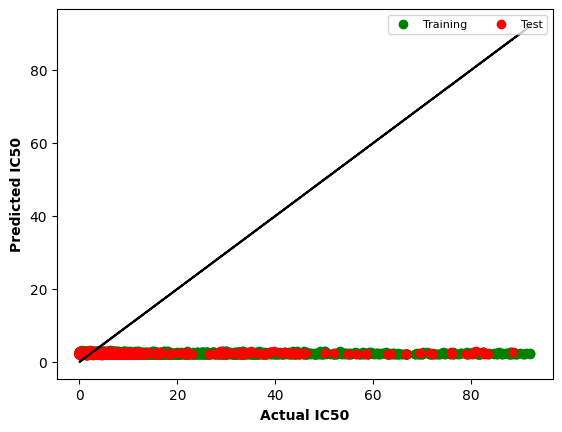

In [17]:
train_logs = eval_epoch(model, train_loader, loss_function, device)
y_train, train_preds = train_logs["targets"], train_logs["preds"]

test_logs = eval_epoch(model, test_loader, loss_function, device)
y_test, test_preds = test_logs["targets"], test_logs["preds"]
score(y_test, test_preds)
plotter(y_train, train_preds, y_test, test_preds)

In [18]:
class ARMAConvModel(torch.nn.Module):
    def __init__(self, input_channels, hidden_dim=64):
        super(ARMAConvModel, self).__init__()
        self.linear = Linear(9, 64)
        self.model = Sequential('x, edge_index, batch', [
                (Dropout(p=0.5), 'x -> x'),
                (ARMAConv(in_channels=input_channels, out_channels=hidden_dim), 'x, edge_index -> x1'),
                ReLU(inplace=True),
                (ARMAConv(hidden_dim, hidden_dim), 'x1, edge_index -> x2'),
                ReLU(inplace=True),
                (lambda x1, x2: [x1, x2], 'x1, x2 -> xs'),
                (JumpingKnowledge("cat", hidden_dim, num_layers=2), 'xs -> x'),
                (global_mean_pool, 'x, batch -> x'),
                Linear(2 * hidden_dim, 1),
            ])

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x.float(), data.edge_index, data.edge_attr.float(), data.batch
        out = self.model(x, edge_index, batch)
        return out

In [19]:
model = ARMAConvModel(9, 64)
learning_rate = 0.001
optimizer = AdamW(model.parameters(), lr=learning_rate)
loss_function = torch.nn.L1Loss()

logs = train(model, train_loader, eval_loader, loss_function, optimizer)

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:03<00:00,  1.67s/it]


{'TRAIN Loss': {3.4357492923736572}, 'MAE': {3.483370780944824}, 'R2': -0.09610621448315548} {'EVAL Loss': {3.2238062620162964}, 'MAE': {3.2058801651000977}, 'R2': -0.07569993833480582, 'preds': tensor([2.8512, 2.9148, 2.7746,  ..., 3.3018, 2.9520, 2.9296]), 'targets': tensor([ 3.6300,  3.0130,  2.5840,  ...,  6.7880, 41.5110,  6.9490])}


100%|██████████| 2/2 [00:03<00:00,  1.78s/it]


{'TRAIN Loss': {3.1450701395670575}, 'MAE': {3.201685905456543}, 'R2': -0.037586444645788086} {'EVAL Loss': {3.261509656906128}, 'MAE': {3.282480001449585}, 'R2': -0.10039242739077925, 'preds': tensor([2.5714, 2.6224, 2.7042,  ..., 2.5709, 2.7067, 2.6615]), 'targets': tensor([5.3370, 0.2760, 0.2990,  ..., 0.1060, 3.1850, 0.4130])}


100%|██████████| 2/2 [00:03<00:00,  1.84s/it]


{'TRAIN Loss': {3.243595314025879}, 'MAE': {3.187436103820801}, 'R2': -0.033728382504657706} {'EVAL Loss': {3.303112268447876}, 'MAE': {3.306697368621826}, 'R2': -0.10649068325433264, 'preds': tensor([2.5845, 2.5133, 2.4736,  ..., 3.0471, 2.4896, 2.5831]), 'targets': tensor([3.9770, 6.5120, 3.7440,  ..., 3.3860, 0.4530, 3.6650])}


100%|██████████| 2/2 [00:03<00:00,  1.85s/it]


{'TRAIN Loss': {3.1620373249053957}, 'MAE': {3.1863479614257812}, 'R2': -0.03181754617813226} {'EVAL Loss': {3.3103100061416626}, 'MAE': {3.3273942470550537}, 'R2': -0.11178529359329237, 'preds': tensor([2.4939, 2.5224, 2.6506,  ..., 2.5592, 2.3806, 2.4076]), 'targets': tensor([5.3230, 3.0380, 5.2780,  ..., 9.0650, 8.9670, 1.0640])}


100%|██████████| 2/2 [00:04<00:00,  2.13s/it]


{'TRAIN Loss': {3.1841495037078857}, 'MAE': {3.1830544471740723}, 'R2': -0.029110508158622705} {'EVAL Loss': {3.366763472557068}, 'MAE': {3.3499083518981934}, 'R2': -0.11765428762499641, 'preds': tensor([2.4399, 2.3108, 2.3696,  ..., 2.4537, 2.4003, 2.5404]), 'targets': tensor([ 4.8900,  3.3930,  4.5500,  ...,  6.9930,  0.6010, 21.0000])}


100%|██████████| 2/2 [00:04<00:00,  2.15s/it]


{'TRAIN Loss': {3.1726329644521076}, 'MAE': {3.183483600616455}, 'R2': -0.02941762420342986} {'EVAL Loss': {3.416923999786377}, 'MAE': {3.4070167541503906}, 'R2': -0.13349545644603844, 'preds': tensor([2.2074, 2.3145, 2.1781,  ..., 2.2339, 2.2859, 2.3046]), 'targets': tensor([ 1.8680,  5.0670,  1.7890,  ...,  0.9350, 14.4070,  7.6320])}


100%|██████████| 2/2 [00:03<00:00,  1.74s/it]


{'TRAIN Loss': {3.1932419459025065}, 'MAE': {3.18027925491333}, 'R2': -0.02996602493008349} {'EVAL Loss': {3.3543659448623657}, 'MAE': {3.3147480487823486}, 'R2': -0.10707593392739145, 'preds': tensor([2.5296, 2.4633, 2.4671,  ..., 2.4723, 2.4463, 2.5839]), 'targets': tensor([3.2920, 1.7830, 6.6830,  ..., 4.2550, 4.3400, 0.3670])}


100%|██████████| 2/2 [00:04<00:00,  2.13s/it]


{'TRAIN Loss': {3.186746581395467}, 'MAE': {3.1823620796203613}, 'R2': -0.02797548932684002} {'EVAL Loss': {3.346933364868164}, 'MAE': {3.354172468185425}, 'R2': -0.11819780311928407, 'preds': tensor([2.4555, 2.3325, 2.3596,  ..., 2.3667, 2.3704, 2.4029]), 'targets': tensor([8.1630, 7.6460, 0.2820,  ..., 1.6570, 3.4040, 0.0730])}


100%|██████████| 2/2 [00:04<00:00,  2.15s/it]


{'TRAIN Loss': {3.205974499384562}, 'MAE': {3.177238702774048}, 'R2': -0.029213808558596233} {'EVAL Loss': {3.372021794319153}, 'MAE': {3.357074022293091}, 'R2': -0.1188680759697005, 'preds': tensor([2.5607, 2.3579, 2.5324,  ..., 2.3703, 2.3660, 2.3507]), 'targets': tensor([4.4880, 2.6870, 3.7690,  ..., 5.1110, 2.7210, 3.3330])}


100%|██████████| 2/2 [00:04<00:00,  2.17s/it]


{'TRAIN Loss': {3.136989227930705}, 'MAE': {3.1758816242218018}, 'R2': -0.026535262828966566} {'EVAL Loss': {3.3920592069625854}, 'MAE': {3.393486976623535}, 'R2': -0.12886246538969282, 'preds': tensor([2.3319, 2.3610, 2.1523,  ..., 2.2813, 2.2763, 2.1705]), 'targets': tensor([0.7670, 0.1080, 2.7730,  ..., 4.4910, 4.1090, 1.8060])}


100%|██████████| 2/2 [00:04<00:00,  2.22s/it]


{'TRAIN Loss': {3.2023895740509034}, 'MAE': {3.177051067352295}, 'R2': -0.027667028025465612} {'EVAL Loss': {3.377527594566345}, 'MAE': {3.361131191253662}, 'R2': -0.11965713126037492, 'preds': tensor([2.3953, 2.5806, 2.3015,  ..., 2.3298, 2.4300, 2.4231]), 'targets': tensor([ 9.3510, 21.0000, 15.7630,  ...,  4.6670,  0.7300,  1.3400])}


100%|██████████| 2/2 [00:03<00:00,  1.82s/it]


{'TRAIN Loss': {3.2844779809316}, 'MAE': {3.175023078918457}, 'R2': -0.02772049949841149} {'EVAL Loss': {3.352940320968628}, 'MAE': {3.3739945888519287}, 'R2': -0.1227455740875949, 'preds': tensor([2.2546, 2.2767, 2.2876,  ..., 2.3673, 2.3426, 2.3249]), 'targets': tensor([3.3630, 2.6470, 1.7680,  ..., 3.4540, 4.3550, 9.3890])}


100%|██████████| 2/2 [00:02<00:00,  1.16s/it]


{'TRAIN Loss': {3.1994082291920978}, 'MAE': {3.1773324012756348}, 'R2': -0.024290555928727198} {'EVAL Loss': {3.4205316305160522}, 'MAE': {3.4272453784942627}, 'R2': -0.13718254857558154, 'preds': tensor([2.2683, 2.2812, 2.1651,  ..., 2.3594, 2.2604, 2.1590]), 'targets': tensor([3.8830, 1.7760, 2.1950,  ..., 3.6860, 7.6310, 4.6810])}


100%|██████████| 2/2 [00:03<00:00,  1.76s/it]


{'TRAIN Loss': {3.176411739985148}, 'MAE': {3.1746230125427246}, 'R2': -0.027120492626979242} {'EVAL Loss': {3.4178744554519653}, 'MAE': {3.4060144424438477}, 'R2': -0.13104831010374363, 'preds': tensor([2.1977, 2.2297, 2.2504,  ..., 2.2420, 2.2253, 2.2772]), 'targets': tensor([3.4050, 2.1060, 2.5410,  ..., 3.2980, 3.2660, 1.2130])}


100%|██████████| 2/2 [00:04<00:00,  2.24s/it]

{'TRAIN Loss': {3.215643533070882}, 'MAE': {3.1741750240325928}, 'R2': -0.02593313921888707} {'EVAL Loss': {3.4858134984970093}, 'MAE': {3.4564924240112305}, 'R2': -0.14490523256993093, 'preds': tensor([2.4381, 2.2142, 2.0600,  ..., 2.0307, 2.0316, 2.0828]), 'targets': tensor([1.1720, 0.0880, 1.8710,  ..., 9.1490, 1.1040, 3.9350])}


100%|██████████| 2/2 [00:04<00:00,  2.43s/it]


Coefficient of determination (R²): -0.13306056309171055
MAE: 3.4463181495666504
MAPE: 38.37912368774414


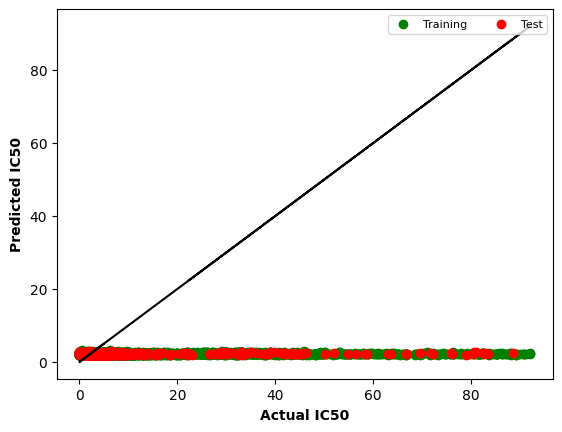

In [21]:
train_logs = eval_epoch(model, train_loader, loss_function, device)
y_train, train_preds = train_logs["targets"], train_logs["preds"]

test_logs = eval_epoch(model, test_loader, loss_function, device)
y_test, test_preds = test_logs["targets"], test_logs["preds"]
score(y_test, test_preds)
plotter(y_train, train_preds, y_test, test_preds)